In [1]:
# 完成卷积神经网络对衣服鞋子数据集的分类，并使用selu激活函数，对比效果
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)# 训练集数据集，下载并加载数据集，并将其转换为张量格式

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)# 测试集数据集，下载并加载数据集，并将其转换为张量格式

# torchvision 数据集里没有提供训练集和验证集的划分
# 这里用 random_split 按照 11 : 1 的比例来划分数据集
train_ds, val_ds = random_split(train_ds, [55000, 5000], torch.Generator().manual_seed(seed))# 划分训练集和验证集

100%|██████████| 26.4M/26.4M [01:46<00:00, 248kB/s] 


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 114kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:14<00:00, 309kB/s] 


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [3]:
from torchvision.transforms import Normalize

# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))# 计算每个通道的均值，dim=(1,2)表示在高度和宽度上进行求和
        std += img.std(dim=(1, 2))# 计算每个通道的方差，dim=(1,2)表示在高度和宽度上进行求和
    mean /= len(ds)# 计算均值和方差的总和，然后除以数据集的大小，得到每个通道的均值和方差
    std /= len(ds)# 计算均值和方差的总和，然后除以数据集的大小，得到每个通道的均值和方差
    return mean, std

# print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2856], [0.3202])# 对每个通道进行标准化，均值和方差分别为0.2856， 0.3202
) # 对每个通道进行标准化

In [4]:
img, label = train_ds[0]# 取出第一张图片和标签，查看图片的形状和标签
img.shape, label# 查看图片的形状和标签，可以看到图片的形状为(1, 28, 28)，标签为0-9的整数

(torch.Size([1, 28, 28]), 9)

In [5]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)# 创建训练集的dataloader，shuffle=True表示打乱数据集
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)# 创建验证集的dataloader，shuffle=False表示不打乱数据集
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)# 创建测试集的dataloader，shuffle=False表示不打乱数据集

In [6]:
class CNN(nn.Module):
    def __init__(self, activation="relu"):
        super(CNN, self).__init__()# 初始化父类，即nn.Module，即初始化父类的属性
        self.activation = F.relu if activation == "relu" else F.selu
        #输入通道数，图片是灰度图，所以是1，图片是彩色图，就是3，输出通道数，就是卷积核的个数（32,1,28,28）
        #输入x(32,1,28,28) 输出x(32,32,28,28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        #输入x(32,32,28,28) 输出x(32,32,28,28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) #池化不能够改变通道数，池化核大小为2（2*2），步长为2  (28-2)//2+1=14
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10) #输出尺寸（32,10）
        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)# 使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W
                nn.init.zeros_(m.bias)# 初始化偏置项为0

    def forward(self, x):
        act = self.activation
        x = self.pool(act(self.conv2(act(self.conv1(x))))) # 1 * 28 * 28 -> 32 * 14 * 14
        # print(x.shape)
        x = self.pool(act(self.conv4(act(self.conv3(x))))) # 32 * 14 * 14 -> 64 * 7 * 7
        # print(x.shape)
        x = self.pool(act(self.conv6(act(self.conv5(x))))) # 64 * 7 * 7 -> 128 * 3 * 3
        # print(x.shape)
        x = self.flatten(x) # 128 * 3 * 3 ->1152
        x = act(self.fc1(x)) # 1152 -> 128
        x = self.fc2(x) # 128 -> 10
        return x

for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}") # 打印模型的参数信息，包括卷积层、全连接层的权重和偏置项

conv1.weight	paramerters num: 288
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 147456
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [7]:
def count_parameters(model): #计算模型总参数量
    return sum(p.numel() for p in model.parameters() if p.requires_grad)# 计算模型总参数量，包括卷积层、全连接层的权重和偏置项

In [8]:
count_parameters(CNN())# 打印模型的参数信息，包括卷积层、全连接层的权重和偏置项

435306

In [9]:
#练习不同尺寸的卷积核，padding，stride的效果
class CNN1(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        #输入通道数，图片是灰度图，所以是1，图片是彩色图，就是3，输出通道数，就是卷积核的个数（32,1,28,28）
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=1,stride=1)
        #输入x(32,32,28,28) 输出x(32,32,28,28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) #池化核大小为2（2*2），步长为2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10) #输出尺寸（32,10）

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        x=act(self.conv1(x)) # 1 * 28 * 28 -> 32 * 28 * 28
        print(x.shape)
        # x=act(self.conv2(x)) # 32 * 28 * 28 -> 32 * 28 * 28
        # print(x.shape)
        # x = self.pool(x) # 32 * 28 * 28 -> 32 * 14 * 14
        # print(x.shape)
        # x=act(self.conv3(x)) # 32 * 14 * 14 -> 64 * 14 * 14
        # print(x.shape)
        # x=act(self.conv4(x)) # 64 * 14 * 14 -> 64 * 14 * 14
        # print(x.shape)
        # x = self.pool(x) # 32 * 14 * 14 -> 64 * 7 * 7
        # print(x.shape)
        # x=act(self.conv5(x)) # 64 * 7 * 7 -> 128 * 7 * 7
        # print(x.shape)
        # x=act(self.conv6(x)) # 128 * 7 * 7 -> 128 * 7 * 7
        # print(x.shape)
        # x = self.pool(x) # 128 * 7 * 7 -> 128 * 3 * 3
        # print(x.shape)
        # x = self.flatten(x) # 128 * 3 * 3 ->1152
        # x = act(self.fc1(x)) # 1152 -> 128
        # x = self.fc2(x) # 128 -> 10
        return x
activation = "relu"
model = CNN1(activation)
# model.to(device)
img = torch.randn(1, 1, 28, 28)# 随机生成一张图片
model(img)

torch.Size([1, 32, 26, 26])


tensor([[[[0.0000, 0.1025, 0.0000,  ..., 0.0481, 0.4678, 0.0376],
          [0.0000, 0.1582, 0.3902,  ..., 0.6329, 0.0000, 0.1080],
          [0.0000, 0.3851, 0.3544,  ..., 0.0000, 0.2825, 0.0000],
          ...,
          [0.0000, 0.2926, 0.0000,  ..., 0.1081, 0.2268, 0.0000],
          [0.0000, 0.0368, 0.2965,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1010,  ..., 0.4492, 0.4848, 0.1346]],

         [[0.4335, 0.5751, 0.0206,  ..., 0.0000, 0.0000, 0.1916],
          [0.1628, 0.0000, 0.0000,  ..., 0.2642, 0.0373, 0.0000],
          [0.1804, 0.0000, 0.7306,  ..., 0.0000, 0.0000, 0.2260],
          ...,
          [0.2437, 0.0000, 0.1471,  ..., 0.0000, 0.3498, 0.0000],
          [0.1943, 0.6858, 0.1112,  ..., 0.2167, 0.0000, 0.0000],
          [0.0587, 0.0000, 0.0000,  ..., 0.0315, 0.0000, 0.0718]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2408, 0.0000, 0.0726],
          [0.0000, 0.0000, 0.1153,  ..., 0.0621, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [10]:

class CNN2(nn.Module):
    def __init__(self, activation="relu"):
        super(CNN, self).__init__()
        self.activation = F.relu if activation == "relu" else F.selu
        #输入通道数，图片是灰度图，所以是1，图片是彩色图，就是3，输出通道数，就是卷积核的个数（32,1,28,28）
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        #输入x(32,32,28,28) 输出x(32,32,28,28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) #池化核大小为2（2*2），步长为2
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        # input shape is (28, 28, 1) so the fc1 layer in_features is 128 * 3 * 3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10) #输出尺寸（32,10）

        self.init_weights()

    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层、卷积层的权重 W"""
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        act = self.activation
        x=act(self.conv1(x)) # 1 * 28 * 28 -> 32 * 28 * 28
        print(x.shape)
        x=act(self.conv2(x)) # 32 * 28 * 28 -> 32 * 28 * 28
        print(x.shape)
        x = self.pool(x) # 32 * 28 * 28 -> 32 * 14 * 14
        print(x.shape)
        x=act(self.conv3(x)) # 32 * 14 * 14 -> 64 * 14 * 14
        print(x.shape)
        x=act(self.conv4(x)) # 64 * 14 * 14 -> 64 * 14 * 14
        print(x.shape)
        x = self.pool(x) # 32 * 14 * 14 -> 64 * 7 * 7
        print(x.shape)
        x=act(self.conv5(x)) # 64 * 7 * 7 -> 128 * 7 * 7
        print(x.shape)
        x=act(self.conv6(x)) # 128 * 7 * 7 -> 128 * 7 * 7
        print(x.shape)
        x = self.pool(x) # 128 * 7 * 7 -> 128 * 3 * 3
        print(x.shape)
        x = self.flatten(x) # 128 * 3 * 3 ->1152
        x = act(self.fc1(x)) # 1152 -> 128
        x = self.fc2(x) # 128 -> 10
        return x

for idx, (key, value) in enumerate(CNN().named_parameters()):
    print(f"{key}\tparamerters num: {np.prod(value.shape)}") # 打印模型的参数信息

conv1.weight	paramerters num: 288
conv1.bias	paramerters num: 32
conv2.weight	paramerters num: 9216
conv2.bias	paramerters num: 32
conv3.weight	paramerters num: 18432
conv3.bias	paramerters num: 64
conv4.weight	paramerters num: 36864
conv4.bias	paramerters num: 64
conv5.weight	paramerters num: 73728
conv5.bias	paramerters num: 128
conv6.weight	paramerters num: 147456
conv6.bias	paramerters num: 128
fc1.weight	paramerters num: 147456
fc1.bias	paramerters num: 128
fc2.weight	paramerters num: 1280
fc2.bias	paramerters num: 10


In [11]:
activation = "relu"# 激活函数
model = CNN(activation)# 创建模型实例
# model.to(device)
# img = torch.randn(1, 1, 28, 28)
# model(img)

In [12]:
from torchviz import make_dot

# Assuming your model is already defined and named 'model'
# Construct a dummy input
dummy_input = torch.randn(1, 1, 28, 28)  # Replace with your input shape

# Forward pass to generate the computation graph
output = model(dummy_input)

# Visualize the model architecture
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_CNN", format="png")# 保存为PNG格式的图片

'model_CNN.png'

In [13]:
#计算参数量
print(f'conv1 - {1*3*3*32}') # 32个卷积核，每个卷积核大小为1*3*3
print(f'conv2 - {32*3*3*32}') # 32个卷积核，每个卷积核大小为32*3*3
print(f'conv3 - {32*3*3*64}')# 64个卷积核，每个卷积核大小为32*3*3
print(f'conv4 - {64*3*3*64}')# 64个卷积核，每个卷积核大小为64*3*3
print(f'conv5 - {64*3*3*128}')# 128个卷积核，每个卷积核大小为64*3*3
print(f'conv6 - {128*3*3*128}')# 128个卷积核，每个卷积核大小为128*3*3
print(f'fc1 - {1152*128}')# 1152个神经元，每个神经元有128个输入
print(f'fc2 - {128*10}')# 128个神经元，每个神经元有10个输入

#对上面求和，总参数数目为：
1*3*3*32 +32+ 32*3*3*32 +32+ 32*3*3*64 +64+ 64*3*3*64+64 + 64*3*3*128 +128+ 128*3*3*128 +128+ 128*3*3*128+128 + 128*10+10

conv1 - 288
conv2 - 9216
conv3 - 18432
conv4 - 36864
conv5 - 73728
conv6 - 147456
fc1 - 147456
fc2 - 1280


435306

In [14]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []# 初始化验证集损失列表
    pred_list = []# 初始化验证集预测列表
    label_list = []# 初始化验证集真实标签列表
    for datas, labels in dataloader:
        datas = datas.to(device)# 将验证集数据送入设备
        labels = labels.to(device)# 将验证集标签送入设备
        # 前向计算
        logits = model(datas)              # 验证集预测
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.cpu().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc # 返回验证集损失均值和准确率


In [15]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)# 初始化TensorBoard回调函数

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))# 绘制模型结构图
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )# 绘制训练和验证损失曲线图
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )# 绘制训练和验证准确率曲线图
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        )# 绘制学习率曲线图
    
    def __call__(self, step, **kwargs):# 绘制训练和验证损失曲线图、准确率曲线图和学习率曲线图
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [16]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)# 创建保存模型文件夹
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))# 保存模型

In [17]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):# 判断是否提前终止训练
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):# 判断是否提前终止训练
        return self.counter >= self.patience


In [18]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):# 训练函数
    record_dict = {
        "train": [],
        "val": []
    }# 记录训练和验证的损失、准确率等信息，用于后续可视化等
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                    
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

activation = "relu"
model = CNN(activation)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback(f"runs/cnn-{activation}")# 绘制模型结构图, 绘制训练和验证的损失、准确率等信息
tensorboard_callback.draw_model(model, [1, 1, 28, 28])# 绘制模型结构图
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")# 保存模型权重
save_ckpt_callback = SaveCheckpointsCallback(f"checkpoints/cnn-{activation}", save_best_only=True)# 保存模型权重
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10)# 早停

In [19]:
model = model.to(device)# 模型迁移到GPU上
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=1000
    )# 训练模型

  0%|          | 0/34380 [00:00<?, ?it/s]

Early stop at epoch 16 / global_step 28000


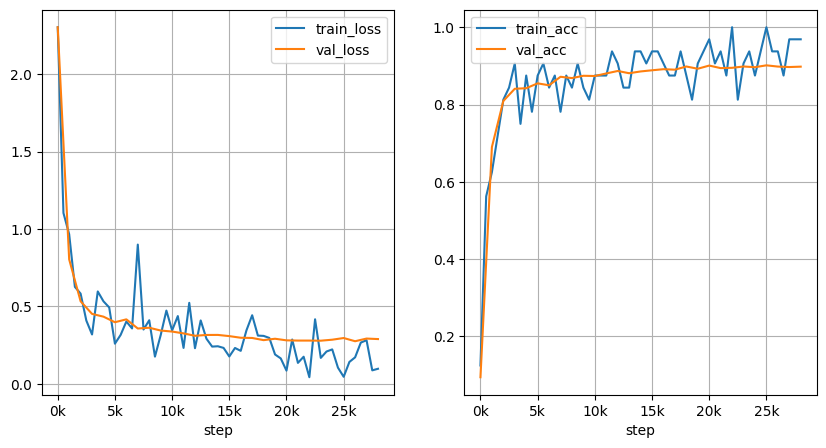

In [20]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]# 每隔500个step取一个点，画出训练和验证的损失、准确率等信息
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")# 每隔500个step取一个点，画出训练和验证的损失、准确率等信息

    # plot
    fig_num = len(train_df.columns)# 画出训练和验证的损失、准确率等信息
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))# 画出训练和验证的损失、准确率等信息
    for idx, item in enumerate(train_df.columns):# 画出训练和验证的损失、准确率等信息    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")#
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")  
    plt.show()
plot_learning_curves(record, sample_step=500)  #横坐标是 steps

In [21]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load(f"checkpoints/cnn-{activation}/best.ckpt", map_location="cpu"))# 加载模型权重

model.eval()# 模型评估模式
loss, acc = evaluating(model, test_loader, loss_fct)# 模型评估
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")# 模型评估结果

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7500\3296966510.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"checkpoints/cnn-{activation

loss:     0.3004
accuracy: 0.8974
